In [63]:
import numpy as np
import pandas as pd
from time import time
import warnings
warnings.filterwarnings(action="ignore", category=DeprecationWarning)

In [64]:
FIRST_SIZE = 2
LAST_SIZE = 64

COUNT_TRIES = 1000

MAX_DEF_COUNT_ITER = 100000
"""Максимальное количество итераций по-умолчанию"""
DEF_EPS = 0.0001
"""Точность по-умолчанию"""

'Точность по-умолчанию'

In [65]:
df = pd.DataFrame(
    columns=[
        "size",
        "true_value_max",
        "true_value_min",
        "value_max",
        "value_max_time",
        "value_min_def",
        "value_min_def_time",
        "value_min_rel",
        "value_min_rel_time"
    ],
    index=range(1, (LAST_SIZE - FIRST_SIZE + 1) * COUNT_TRIES + 1),
)
df

,size,true_value_max,true_value_min,value_max,value_max_time,value_min_def,value_min_def_time,value_min_rel,value_min_rel_time
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
62996,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
62997,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
62998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
62999,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Подготовка

In [66]:
def calc(A: np.matrix, b: np.matrix) -> np.matrix:
    if b is None:
        print("Вектор собственного значения не был посчитан")
        return None
    return float((b.T @ A @ b) / (b.T @ b))

# Прямой метод

$x^{(k)} = \dfrac{Ax^{(k - 1)}}{\alpha_{k - 1}}$

$\lambda_{1}(A) = \dfrac{\left( Ax^{(k)}, x^{(k)} \right)}{(x^{(k)}, x^{(k)})} = \dfrac{(x^{(k)})^{T}A^{(k)}x^{(k)}}{(x^{(k)})^{T}x^{(k)}}$, где $|\lambda_1(A)|$ - наибольшее по модулю СЗ

In [67]:
def power_iteration(
    A: np.matrix,
    epsilon: float = DEF_EPS,
    num_iterations=MAX_DEF_COUNT_ITER,
    b_k: np.matrix = None,
) -> np.matrix:
    if b_k is None:
        b_k = np.random.rand(A.shape[1], 1)
    # print("Начальное приближение:", b_k, sep="\n")

    alpha_old = None

    # for _ in range(num_iterations):
    while True:
        b_k1 = np.dot(A, b_k)

        b_k1_norm = np.linalg.norm(b_k1)

        b_k = b_k1 / b_k1_norm

        alpha_new = calc(A, b_k)
        if alpha_old is not None and abs(alpha_new - alpha_old) < epsilon:
            break
        alpha_old = alpha_new

    return b_k, alpha_new

# Обратный метод

## Стандартная версия

In [68]:
def inverse_power_def(
    A: np.matrix,
    epsilon: float = DEF_EPS,
    num_iterations=MAX_DEF_COUNT_ITER,
    b_k: np.matrix = None,
) -> np.matrix:
    try:
        inv_A = np.linalg.inv(A)
    except np.linalg.LinAlgError:
        print("Вырожденная матрица")
        return None
    # print("Обратная матрица:",inv_A, sep="\n")
    res = power_iteration(
        A = inv_A, epsilon=epsilon, num_iterations=num_iterations, b_k=b_k
    )
    return res[0], 1 / res[1]

In [69]:
# A: np.matrix = np.matrix("1 3 -2 0;"
#                          "1 1 4 7;"
#                          "4 7 11 23;"
#                          "52 66 2 0")  # -0.65
# calc(A, inverse_power_def(A))

## Модификация Релэя

In [70]:
import random


def inverse_power_rel(
    A, epsilon: float = DEF_EPS, num_iterations=MAX_DEF_COUNT_ITER, mu=None, b_k=None
):
    if b_k is None:
        b_k = np.random.rand(
            A.shape[1], 1
        )  # Попробовать близкий к настоящему собственный вектор
    if mu is None:
        mu = random.randint(1, 10)  # Случайное начальное приближение
    #   print("Начальное приближение:", "СЗ:", mu, "СВ:", b_k, sep="\n")

    b_k = b_k / np.linalg.norm(b_k)
    y = np.linalg.solve(A - mu * np.eye(A.shape[0]), b_k)
    lambda_ = float(np.dot(y.T, b_k))
    # print(lambda_, lambda_ * x)
    mu = mu + 1 / lambda_
    #   mu = calc(A, b_k)
    err = np.linalg.norm(y - lambda_ * b_k) / np.linalg.norm(y)

    index = 0
    while err > epsilon and index < num_iterations:
        b_k = y / np.linalg.norm(y)
        y = np.linalg.solve(A - mu * np.eye(A.shape[0]), b_k)
        lambda_ = float(np.dot(y.T, b_k))
        mu = mu + 1 / lambda_
        err = np.linalg.norm(y - lambda_ * b_k) / np.linalg.norm(y)
        index += 1

    return b_k, float(mu)

In [71]:
def inverse_power_rel(A, epsilon = DEF_EPS, mu = None, b_k = None):
  if b_k is None:
      b_k = np.random.rand(A.shape[1], 1) # Попробовать близкий к настоящему собственный вектор
  if mu is None:
    mu = random.randint(1, 1000) / 100
#   print("R:\n", mu, " ", b_k, "\n")
  
  b_k = b_k / np.linalg.norm(b_k)
  y = np.linalg.solve(A - mu * np.eye(A.shape[0]), b_k)
  # print(y)
  # print(x)
  lambda_ = float(np.dot(y.T, b_k))
  # print(lambda_, lambda_ * x)
  mu = mu + 1 / lambda_
  err = np.linalg.norm(y - lambda_ * b_k) / np.linalg.norm(y)

  while err > epsilon:
    b_k = y / np.linalg.norm(y)
    y = np.linalg.solve(A - mu * np.eye(A.shape[0]), b_k)
    lambda_ = float(np.dot(y.T, b_k))
    mu = mu + 1 / lambda_
    err = np.linalg.norm(y - lambda_ * b_k) / np.linalg.norm(y)

  return b_k, float(mu)

In [72]:
A: np.matrix = np.matrix("1 -2 -1;"
                         "-1 1 1;"
                         "1 0 -1")  # 0, 2, -1
# Сильно зависит от начального приближения
# Не вижу в ней смысла
inverse_power_rel(A)[1]
# calc(A, inverse_power_rel(A)[0])

2.0000000000050706

## Модификация Арнольди

In [73]:
def arnoldi_iteration(A, n: int, epsilon: float = DEF_EPS, b_k=None):
    """Compute a basis of the (n + 1)-Krylov subspace of the matrix A.

    This is the space spanned by the vectors {b, Ab, ..., A^n b}.

    Parameters
    ----------
    A : array_like
        An m times m array.
    b_k : array_like
        Initial vector (length m).
    n : int
        One less than the dimension of the Krylov subspace, or equivalently the *degree* of the Krylov space. Must be >= 1.

    Returns
    -------
    Q : numpy.array
        An m x (n + 1) array, where the columns are an orthonormal basis of the Krylov subspace.
    h : numpy.array
        An (n + 1) x n array. A on basis Q. It is upper Hessenberg.
    """
    if b_k is None:
        b_k = np.random.rand(A.shape[1], 1).ravel()
    eps = epsilon
    h = np.zeros((n + 1, n))
    Q = np.zeros((A.shape[0], n + 1))
    # Normalize the input vector
    Q[:, 0] = b_k / np.linalg.norm(b_k, 2)  # Use it as the first Krylov vector
    for k in range(1, n + 1):
        v = np.dot(A, Q[:, k - 1])  # Generate a new candidate vector
        for j in range(k):  # Subtract the projections on previous vectors
            h[j, k - 1] = np.dot(Q[:, j].conj(), v)
            v = v - h[j, k - 1] * Q[:, j]
        h[k, k - 1] = np.linalg.norm(v, 2)
        if h[k, k - 1] > eps:  # Add the produced vector to the list, unless
            Q[:, k] = v / h[k, k - 1]
        else:  # If that happens, stop iterating.
            return Q, h
    return Q, h

In [74]:
A: np.matrix = np.matrix("1 -2 -1;"
                         "-1 1 1;"
                         "1 0 -1")  # 0, 2, -1
# arnoldi_iteration(A=A, n=3)

# Вычисление

In [75]:
def output(
    A: np.matrix,
    texts: list[str],
    funcs: list,
    num_iterrations: int = MAX_DEF_COUNT_ITER,
    b_k: np.matrix = None,
    mu: float = None,
) -> tuple[np.matrix, list[float | None]]:

    eigs = np.linalg.eigvals(A)
    # print(type(eigs[0]))
    if any(isinstance(eig, np.complex128) for eig in eigs):
        print(eigs)

    abs_v = np.abs(np.linalg.eigvals(A))

    abs_v_max = np.max(abs_v)

    abs_v_min = np.min(abs_v)
    # print(

    #     "Собственные значения матрицы A",

    #     f"Максимальное: {abs_v_max}",
    #     f"Минимальное: {abs_v_min}",
    #     sep="\n",
    # )

    # print("========")

    mass_eval = []

    for text, f in zip(texts, funcs):
        start_time = time()
        # print(text)
        if f.__name__ != inverse_power_rel.__name__:
            evec, eval = f(A=A, num_iterations=num_iterrations, b_k=b_k)
            # evec = f(A=A, num_iterations=num_iterrations, b_k=b_k)
            # eval = calc(A, evec)
        else:
            evec, eval = f(A=A, b_k=b_k, mu=mu)
        stop_time = time()
        # print("========")
        mass_eval.append(abs(eval))
        mass_eval.append(stop_time - start_time)

    # print(text_1)

    # first_evec = f_1(A=A, num_iterations=num_iterrations, b_k=b_k)

    # first_eval = calc(A, first_evec)
    # print("========")

    # print(text_2)

    # if f_2.__name__ != inverse_power_rel.__name__:

    #     second_evec = f_2(A=A, num_iterations=num_iterrations, b_k=b_k)

    #     second_eval = calc(A, second_evec)

    # else:

    #     second_evec, second_eval = f_2(A=A, b_k=b_k, mu=mu)
    # print("========")

    # print(

    #     "Собственные векторы:",

    #     f"{text_1}:",
    #     first_evec,

    #     f"{text_2}:",

    #     second_evec,

    #     sep="\n",
    # )
    # print(

    #     "Собственные значения:",

    #     f"{text_1}: {first_eval}",

    #     f"{text_2}: {second_eval}",

    #     sep="\n",
    # )

    return A.shape[0], abs_v_max, abs_v_min, *mass_eval

In [76]:
def generate_non_singular(n):
    while True:
        # Генерируем случайную матрицу n x n
        matrix = np.random.rand(n, n)  # Вы можете использовать np.random.randint для целых чисел.
        if np.linalg.det(matrix) != 0:  # Проверяем, что определитель не равен нулю
            return matrix

In [77]:
import numpy as np
# texts = ["Прямые итерации", "Обратные итерации (обычные)", "Обратные итерации (Арнольди)"]
# funcs = [power_iteration, inverse_power_def, arnoldi_iteration]
texts = ["Прямые итерации", "Обратные итерации (обычные)", "Обратные итерации (Релэя)"]
funcs = [power_iteration, inverse_power_def, inverse_power_rel]
# texts = ["Прямые итерации", "Обратные итерации (обычные)"]
# funcs = [power_iteration, inverse_power_def]
mass = []

for i in range(FIRST_SIZE, LAST_SIZE + 1):
    print(f"Current size:{i}")
    for j in range(COUNT_TRIES):
        print(j + 1)
        matr = generate_non_singular(i)
        matr = matr @ matr.T
        # TODO: Комплексные корни???
        # В вычислениях проверять на комплексные корни
        df.iloc[(i - FIRST_SIZE) * COUNT_TRIES + j] = output(matr, texts, funcs)
    print()

df["delta_max"] = abs(df["true_value_max"] - df["value_max"])
df["delta_min_def"] = abs(df["true_value_min"] - df["value_min_def"])
df["delta_min_rel"] = abs(df["true_value_min"] - df["value_min_rel"])

df

Current size:2
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
2

,size,true_value_max,true_value_min,value_max,value_max_time,value_min_def,value_min_def_time,value_min_rel,value_min_rel_time,delta_max,delta_min_def,delta_min_rel
1,2,0.641364,0.083332,0.641363,0.001001,0.083332,0.0,0.083332,0.000998,0.000002,0.0,0.0
2,2,1.504458,0.015712,1.504458,0.0,0.015712,0.001006,1.504458,0.0,0.0,0.0,1.488746
3,2,1.320747,0.103563,1.320747,0.0,0.103563,0.0,1.320747,0.001016,0.0,0.0,1.217184
4,2,1.497755,0.004314,1.497755,0.0,0.004314,0.00099,0.004314,0.0,0.0,0.0,0.0
5,2,0.564822,0.000514,0.564822,0.0,0.000514,0.0,0.564822,0.000998,0.0,0.0,0.564308
...,...,...,...,...,...,...,...,...,...,...,...,...
62996,64,1037.768391,0.002221,1037.768391,0.0,0.002221,0.004913,6.0144,0.022631,0.0,0.0,6.012179
62997,64,1008.601824,0.000001,1008.601824,0.000629,0.000001,0.008513,2.575096,0.095522,0.0,0.0,2.575095
62998,64,1048.815736,0.000336,1048.815736,0.00054,0.000336,0.003675,5.890369,0.021441,0.0,0.0,5.890034
62999,64,999.095235,0.000372,999.095235,0.000587,0.000372,0.00477,2.264424,0.045831,0.0,0.0,2.264052


In [78]:
df

,size,true_value_max,true_value_min,value_max,value_max_time,value_min_def,value_min_def_time,value_min_rel,value_min_rel_time,delta_max,delta_min_def,delta_min_rel
1,2,0.641364,0.083332,0.641363,0.001001,0.083332,0.0,0.083332,0.000998,0.000002,0.0,0.0
2,2,1.504458,0.015712,1.504458,0.0,0.015712,0.001006,1.504458,0.0,0.0,0.0,1.488746
3,2,1.320747,0.103563,1.320747,0.0,0.103563,0.0,1.320747,0.001016,0.0,0.0,1.217184
4,2,1.497755,0.004314,1.497755,0.0,0.004314,0.00099,0.004314,0.0,0.0,0.0,0.0
5,2,0.564822,0.000514,0.564822,0.0,0.000514,0.0,0.564822,0.000998,0.0,0.0,0.564308
...,...,...,...,...,...,...,...,...,...,...,...,...
62996,64,1037.768391,0.002221,1037.768391,0.0,0.002221,0.004913,6.0144,0.022631,0.0,0.0,6.012179
62997,64,1008.601824,0.000001,1008.601824,0.000629,0.000001,0.008513,2.575096,0.095522,0.0,0.0,2.575095
62998,64,1048.815736,0.000336,1048.815736,0.00054,0.000336,0.003675,5.890369,0.021441,0.0,0.0,5.890034
62999,64,999.095235,0.000372,999.095235,0.000587,0.000372,0.00477,2.264424,0.045831,0.0,0.0,2.264052


In [79]:
df.sort_values("delta_max", ascending=False).head(10)

,size,true_value_max,true_value_min,value_max,value_max_time,value_min_def,value_min_def_time,value_min_rel,value_min_rel_time,delta_max,delta_min_def,delta_min_rel
714,2,0.927495,0.771598,0.927285,0.001011,0.771695,0.0,0.927495,0.0,0.000209,0.000096,0.155896
228,2,0.670407,0.491324,0.670294,0.0,0.491347,0.0,0.670407,0.000992,0.000113,0.000023,0.179083
148,2,0.439921,0.336984,0.439826,0.0,0.337,0.001076,0.439921,0.000056,0.000095,0.000016,0.102937
386,2,0.789229,0.516883,0.78918,0.001003,0.5169,0.0,0.789229,0.0,0.000048,0.000017,0.272346
970,2,0.858722,0.528206,0.858675,0.0,0.528219,0.0,0.528206,0.000999,0.000046,0.000013,0.0
261,2,0.721552,0.405554,0.721508,0.001008,0.405558,0.0,0.721552,0.001,0.000045,0.000003,0.315998
986,2,1.146015,0.618109,1.145975,0.0,0.618114,0.001001,1.146015,0.0,0.00004,0.000006,0.527907
955,2,1.132653,0.709918,1.13262,0.0,0.709932,0.001026,1.132653,0.0,0.000034,0.000014,0.422735
1631,3,1.247221,0.02662,1.247193,0.0,0.02662,0.000996,0.7237,0.0,0.000028,0.0,0.69708
1022,3,1.428763,0.014437,1.428741,0.0,0.014437,0.001212,1.428763,0.000532,0.000021,0.0,1.414326


In [80]:
df.sort_values("delta_min_def", ascending=False).head(10)

,size,true_value_max,true_value_min,value_max,value_max_time,value_min_def,value_min_def_time,value_min_rel,value_min_rel_time,delta_max,delta_min_def,delta_min_rel
714,2,0.927495,0.771598,0.927285,0.001011,0.771695,0.0,0.927495,0.0,0.000209,0.000096,0.155896
1073,3,3.124613,0.398007,3.124612,0.0,0.398034,0.0,3.124613,0.001005,0.0,0.000027,2.726606
1674,3,2.304873,0.394267,2.304871,0.0,0.394294,0.000637,2.304873,0.000673,0.000002,0.000027,1.910606
1291,3,3.452514,0.275037,3.452514,0.001011,0.275062,0.001007,3.452514,0.0,0.0,0.000025,3.177477
228,2,0.670407,0.491324,0.670294,0.0,0.491347,0.0,0.670407,0.000992,0.000113,0.000023,0.179083
1157,3,2.317947,0.168305,2.317947,0.0,0.168326,0.001004,2.317947,0.001152,0.0,0.000021,2.149642
386,2,0.789229,0.516883,0.78918,0.001003,0.5169,0.0,0.789229,0.0,0.000048,0.000017,0.272346
1624,3,2.733951,0.298806,2.733951,0.0,0.298822,0.001033,2.733951,0.0,0.0,0.000017,2.435146
148,2,0.439921,0.336984,0.439826,0.0,0.337,0.001076,0.439921,0.000056,0.000095,0.000016,0.102937
955,2,1.132653,0.709918,1.13262,0.0,0.709932,0.001026,1.132653,0.0,0.000034,0.000014,0.422735


In [81]:
df.sort_values("delta_min_rel", ascending=False).head(10)

,size,true_value_max,true_value_min,value_max,value_max_time,value_min_def,value_min_def_time,value_min_rel,value_min_rel_time,delta_max,delta_min_def,delta_min_rel
32858,34,305.73789,0.002542,305.73789,0.0,0.002542,0.0,305.73789,0.010877,0.0,0.0,305.735348
19721,21,117.299048,0.001907,117.299048,0.0,0.001907,0.002037,117.299048,0.002373,0.0,0.0,117.297141
13889,15,54.032715,0.002141,54.032715,0.0,0.002141,0.000575,54.032715,0.000621,0.0,0.0,54.030574
12229,14,45.797836,0.007932,45.797836,0.0,0.007933,0.002448,45.797836,0.00108,0.0,0.0,45.789903
11361,13,45.018151,0.004132,45.018151,0.0,0.004132,0.000998,45.018151,0.000997,0.0,0.0,45.014019
12011,14,44.658557,0.001277,44.658557,0.0,0.001277,0.001,44.658557,0.0,0.0,0.0,44.65728
10756,12,44.314969,0.000965,44.314969,0.0,0.000965,0.001048,44.314969,0.0,0.0,0.0,44.314004
11550,13,44.139649,0.001921,44.139649,0.001007,0.001921,0.001,44.139649,0.0,0.0,0.0,44.137728
12886,14,43.856048,0.014102,43.856048,0.0,0.014102,0.00099,43.856048,0.0,0.0,0.0,43.841947
11189,13,43.784504,0.013816,43.784504,0.001417,0.013816,0.0,43.784504,0.001029,0.0,0.0,43.770688


# Графическая часть

In [82]:
import matplotlib.pyplot as plt

In [94]:
res_df = df[["size", "value_max_time", "value_min_def_time", "delta_max", "delta_min_def", "delta_min_rel"]]
figsize = (18, 6)
b_k = range(FIRST_SIZE, LAST_SIZE + 1)
x_lt = np.linspace(FIRST_SIZE, LAST_SIZE)
res_df

,size,value_max_time,value_min_def_time,delta_max,delta_min_def,delta_min_rel
1,2,0.001001,0.0,0.000002,0.0,0.0
2,2,0.0,0.001006,0.0,0.0,1.488746
3,2,0.0,0.0,0.0,0.0,1.217184
4,2,0.0,0.00099,0.0,0.0,0.0
5,2,0.0,0.0,0.0,0.0,0.564308
...,...,...,...,...,...,...
62996,64,0.0,0.004913,0.0,0.0,6.012179
62997,64,0.000629,0.008513,0.0,0.0,2.575095
62998,64,0.00054,0.003675,0.0,0.0,5.890034
62999,64,0.000587,0.00477,0.0,0.0,2.264052


In [95]:
max(res_df["delta_min_def"])

9.630377240410493e-05

In [96]:
max(res_df["delta_min_rel"])

305.735348042473

In [97]:
mean_df = res_df.groupby("size").mean()
mean_df

,value_max_time,value_min_def_time,delta_max,delta_min_def,delta_min_rel
size,,,,,
2,0.000129,0.00035,0.000001,0.0,1.085804
3,0.00017,0.000455,0.000001,0.0,2.336241
4,0.000185,0.000464,0.000001,0.0,3.919022
5,0.00019,0.000424,0.0,0.0,5.274816
6,0.000209,0.000422,0.0,0.0,6.432983
...,...,...,...,...,...
60,0.000227,0.004591,0.0,0.0,4.790891
61,0.000215,0.004675,0.0,0.0,4.882879
62,0.000222,0.005041,0.0,0.0,4.819248


In [98]:
max(mean_df['delta_min_def']), max(mean_df['delta_min_rel'])

(2.3210948014631546e-07, 7.485457955207276)

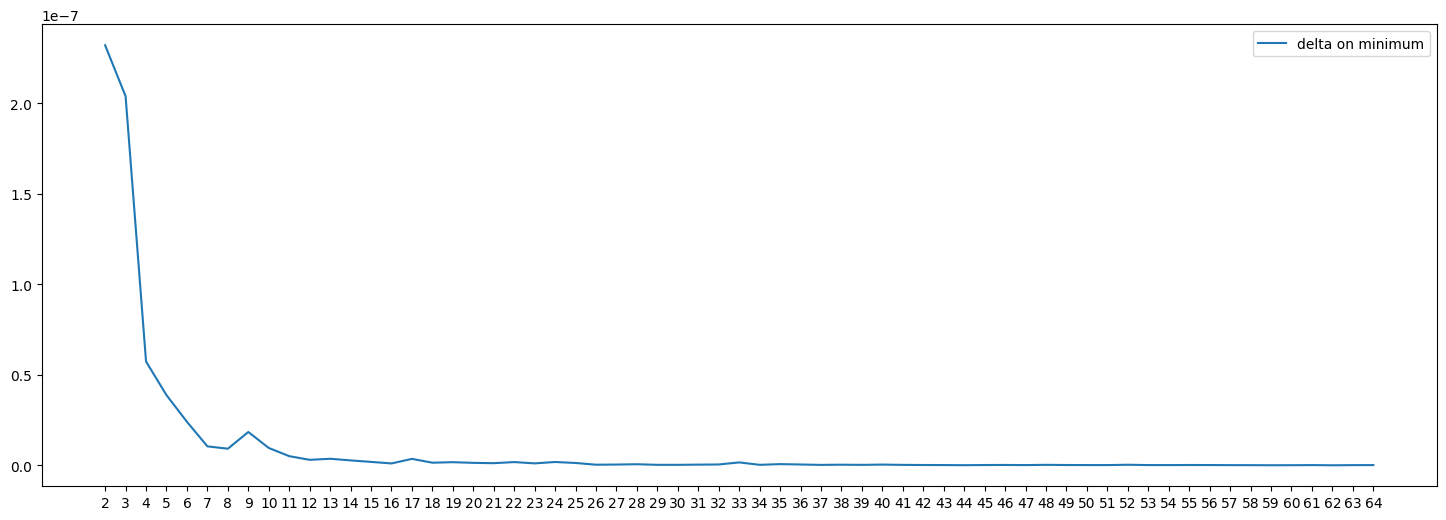

In [99]:

plt.figure(figsize=figsize)
plt.xticks(ticks=b_k)

plt.plot(mean_df["delta_min_def"])
plt.legend(["delta on minimum"])
# mean_res.plot()

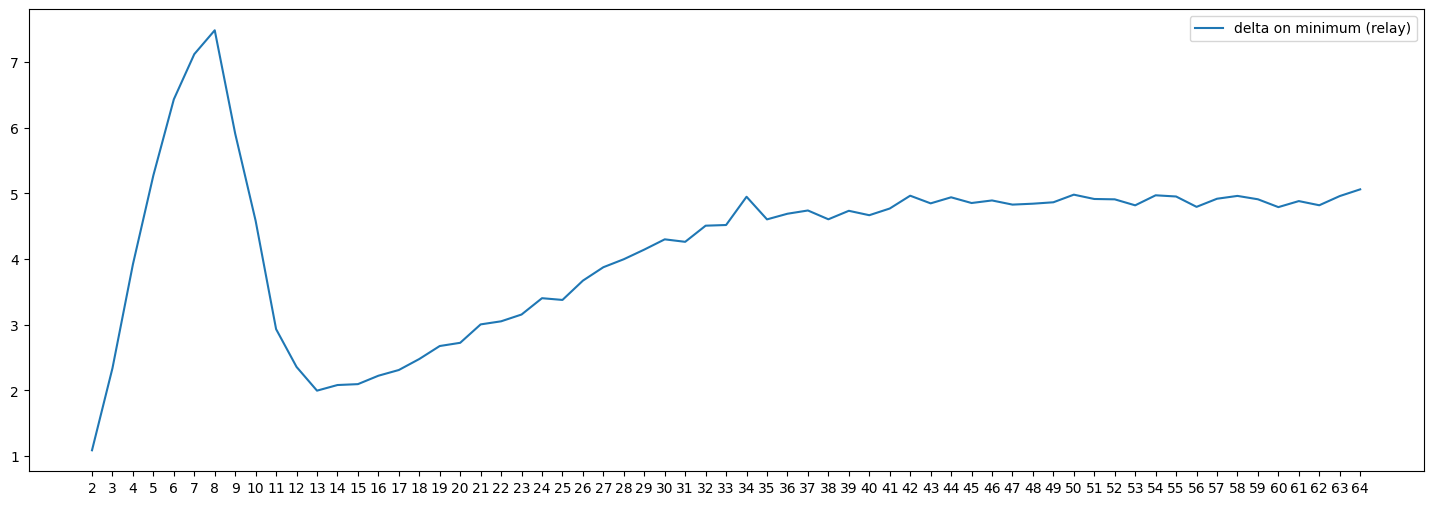

In [100]:

plt.figure(figsize=figsize)
plt.xticks(ticks=b_k)

plt.plot(mean_df["delta_min_rel"])
plt.legend(["delta on minimum (relay)"])
# mean_res.plot()

1.051432744715572e-06


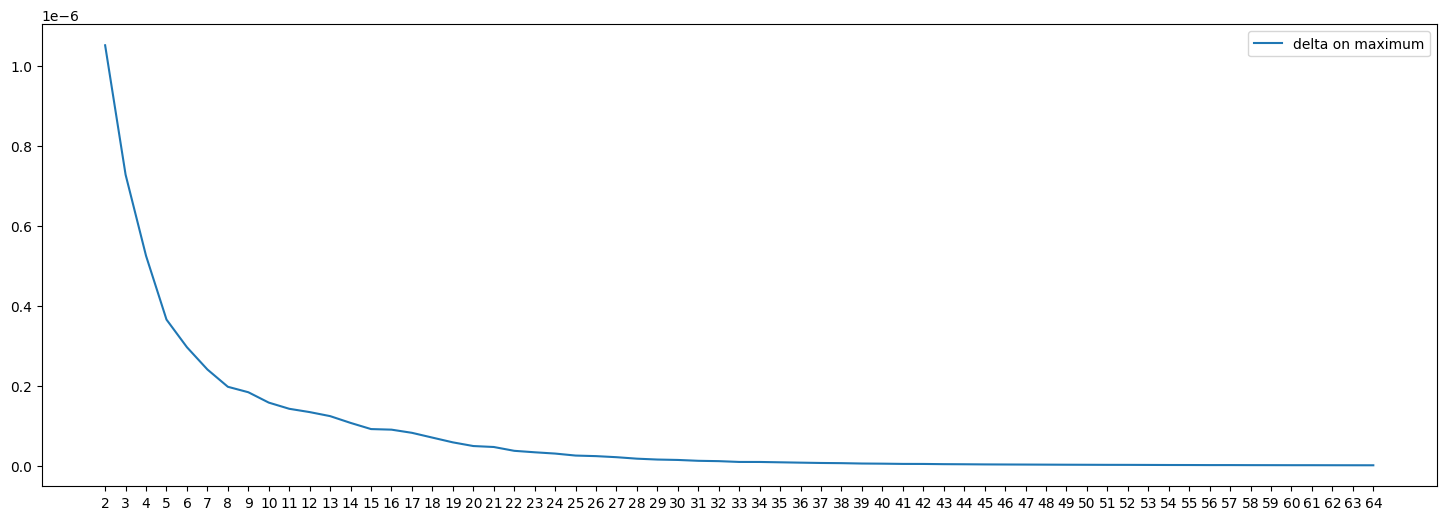

In [101]:
print(max(mean_df['delta_max']))
plt.figure(figsize=figsize)
plt.xticks(ticks=b_k)
plt.plot(mean_df["delta_max"])
plt.legend(["delta on maximum"])

<Figure size 1800x600 with 0 Axes>

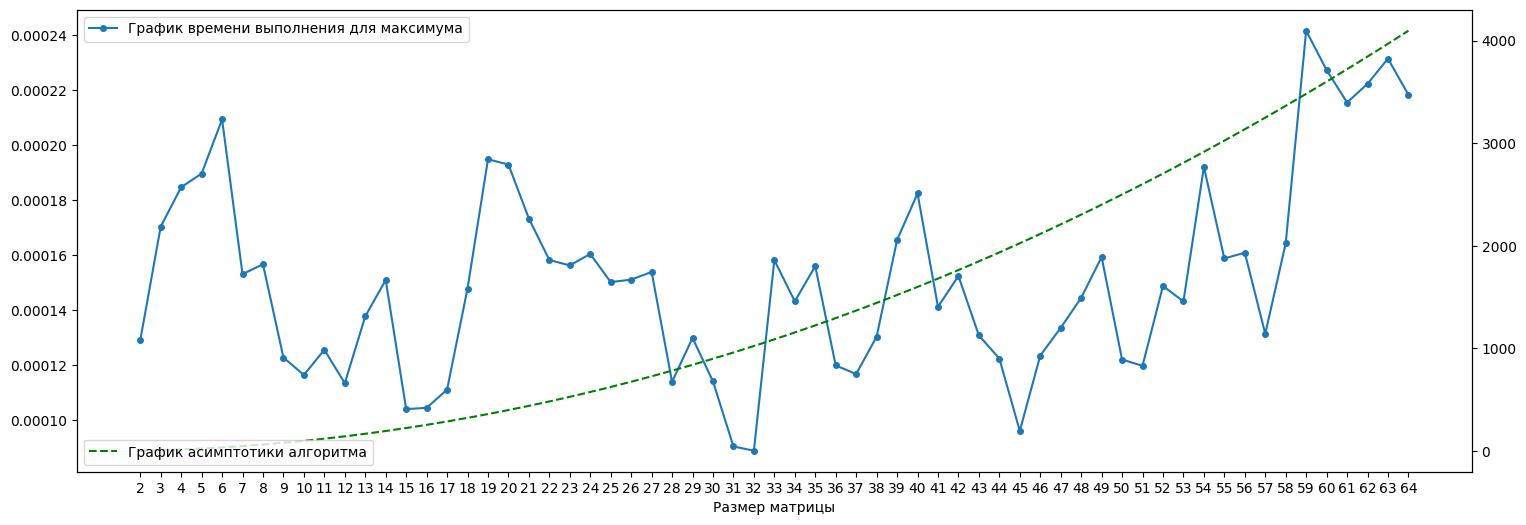

In [102]:
plt.figure(figsize=figsize)

fig, ax1 = plt.subplots(figsize=figsize)

ax1.plot(mean_df['value_max_time'],  marker='o',  markersize=4, label='График времени выполнения для максимума')
ax1.set_xlabel('Размер матрицы')
ax1.set_xticks(b_k)

ax2 = ax1.twinx()

ax2.plot(x_lt, x_lt ** 2, color='green', linestyle='--', label='График асимптотики алгоритма')

ax1.legend(loc='upper left')
ax2.legend(loc='lower left')

plt.show()
# plt.xticks(ticks=x)
# plt.legend(["time for calculation of maximum"])


<Figure size 1800x600 with 0 Axes>

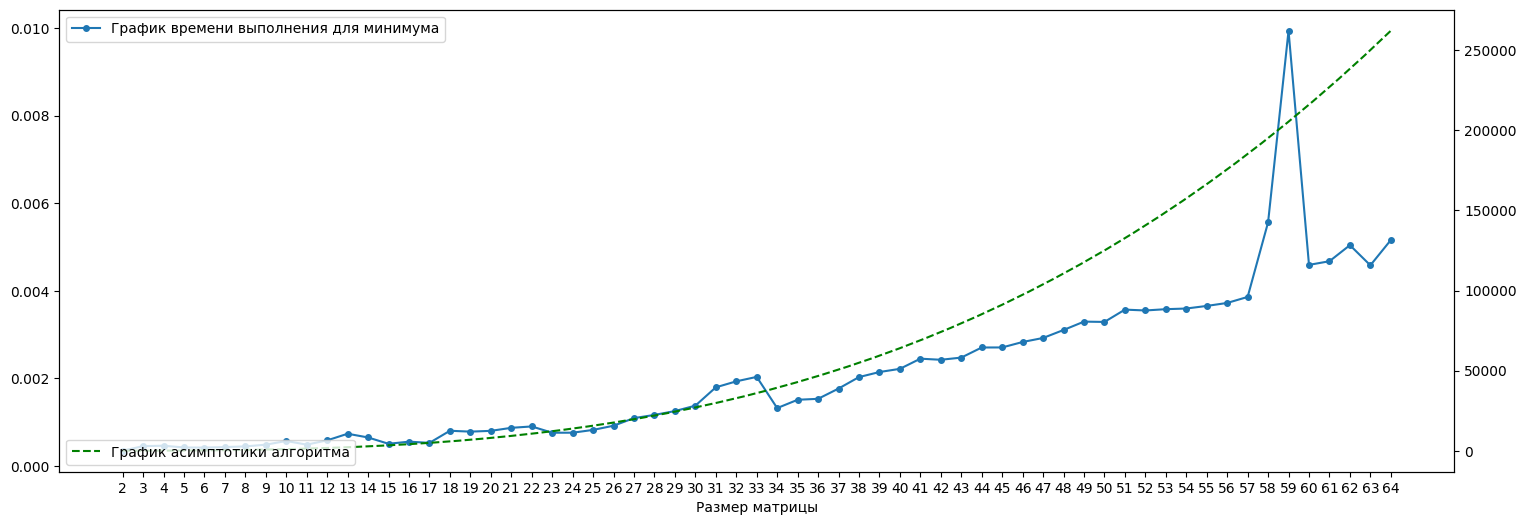

In [103]:
plt.figure(figsize=figsize)

fig, ax1 = plt.subplots(figsize=figsize)

ax1.plot(mean_df['value_min_def_time'],  marker='o',  markersize=4, label='График времени выполнения для минимума')
ax1.set_xlabel('Размер матрицы')
ax1.set_xticks(b_k)

ax2 = ax1.twinx()

ax2.plot(x_lt, x_lt ** 3, color='green', linestyle='--', label='График асимптотики алгоритма')

ax1.legend(loc='upper left')
ax2.legend(loc='lower left')
# plt.plot(x=x, y=x**2)
# plt.legend(["time for calculation of minimum"])
plt.show()

In [105]:
df.to_csv("data/df.csv")
mean_df.to_csv("data/mean_df.csv")
res_df.to_csv("data/res_df.csv")